In [1]:
import os
import sys
from importlib import reload
from pathlib import Path

import dask
import h5py
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import skimage
from dask.diagnostics import ProgressBar
from IPython.display import display
from lmfit import CompositeModel, Model, fit_report
from lmfit.models import (
    ConstantModel,
    DoniachModel,
    GaussianModel,
    LorentzianModel,
    VoigtModel,
)
from scipy.ndimage import gaussian_filter
from skimage import transform

import sed
from sed import SedProcessor

# import spotsize
# from importlib import reload

In [2]:
#%config Completer.use_jedi = False
from datetime import datetime

import pandas as pd
import xarray as xr
from lmfit import CompositeModel, Model, Parameters
from lmfit.lineshapes import exponential, gaussian, step, voigt
from lmfit.models import ConstantModel
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

%matplotlib inline
from scipy.optimize import curve_fit

# import math
# import scipy as sp


def convolve(arr, kernel):
    """Simple convolution of two arrays."""
    npts = min(arr.size, kernel.size)
    pad = np.ones(npts)
    tmp = np.concatenate((pad * arr[0], arr, pad * arr[-1]))
    out = np.convolve(tmp, kernel, mode="valid")
    noff = int((len(out) - npts) / 2)
    return out[noff : noff + npts]


def f1(x, A1, A2, t1, t2, c):
    return (exponential(x, A1, t1) + exponential(x, A2, t2)) * step(x, 1, c, 0)


DDecay = CompositeModel(Model(f1), Model(gaussian), convolve)

# from importlib import reload
# from processor.DldFlashDataframeCreator import DldFlashProcessor


def rescale(array, level1, level2):
    a = np.copy(array)
    M, m = np.nanmax(a), np.nanmin(a)
    s1 = level2 / level1
    s2 = (1 - level2) / (1 - level1)
    o = 1 - s2
    A = (a - m) / (M - m) * s1
    A[A > level2] = s2 / s1 * A[A > level2] + o
    return A * (M - m) + m


def t2e(t, toff, eoff, l=0.75):
    c = 0.5 * 1e18 * 9.10938e-31 / 1.602177e-19
    e = c * (l / (t - toff)) ** 2 - eoff
    return e


def e2t(e, toff, eoff, l=0.75):
    c = 0.5 * 1e18 * 9.10938e-31 / 1.602177e-19
    t = l * np.sqrt(c / (e + eoff)) + toff
    return t


def gauss(x, A, m, s, c):
    return A * np.exp(-((x - m) ** 2) / (2 * s**2)) / np.sqrt(2 * np.pi * s**2) + c


def gaussDistribution(x, A, mean, sigma, offset=0):
    return (
        A * 0.5 * (1 + sp.special.erf((x - mean) / (np.sqrt(2 * sigma**2)))) + offset
    )


def Bin1D(Data, n):
    l = len(Data)
    return sum([Data[i : l - n + 1 + i : n] for i in range(n)])

In [3]:
config = "Scholz_Wind_update.yaml"

In [4]:
from scipy.optimize import curve_fit
from scipy.special import erfc


def gaussian(x, amp, cen, wid, c):
    return (amp * np.exp(-4 * np.log(2) * ((x - cen) / wid) ** 2)) + c

In [5]:
plt.rcParams["font.size"] = 20

In [6]:
# Specify the folder name
folder_name = "C1s_Lineshapebb"
# Run = "50131"

# Check if the folder already exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'C1s_Lineshapebb' already exists.


In [7]:
run_numbers = ["50127", "50128", "50129", "50130"]

# Cut out

## Cut out for  pumpProbeTime less than zero (t > t0)

In [ ]:
senorm_results = {}  # Dictionary to store senorm for each run
seb_results = {}  # Dictionary to store seb for each run


def process_and_plot_runs(run_numbers):

    for run_number in run_numbers:
        # Define the name for the current run
        run_name = f"C1s_{run_number}"
        print(f"Processing {run_name}")

        # Initialize the SedProcessor with the current run number
        exec(
            f"{run_name} = SedProcessor("
            f"runs=[{run_number}], "
            "config=config, "
            "collect_metadata=True, "
            "save_parquet=True, "
            "force_recreate=True)"
        )

        # Access the dynamically created variable
        se = locals()[run_name]

        # Processing steps
        se.add_jitter()
        se.append_energy_axis()

        se._dataframe["energy"] += 229

        t0 = 3.53952100e03
        se._dataframe["pumpProbeTime"] = t0 - se._dataframe["delayStage"]

        # Filter the data to include only rows where pumpProbeTime <= 0
        se._dataframe = se._dataframe[se._dataframe["pumpProbeTime"] <= 0]

        ranges = [[-60, -52], [-1.53, 0]]  # Adjust range to end at 0
        bins = [200, 160]

        axes = ["energy", "pumpProbeTime"]
        seb = se.compute(axes=axes, ranges=ranges, bins=bins)  # Compute seb

        # Store seb in the dictionary with run_name as the key
        seb_results[run_name] = seb

        senorm = seb / seb.mean("energy")

        # Store senorm in the dictionary with run_name as the key
        senorm_results[run_name] = senorm

        # Plotting
        plt.figure(figsize=(15, 9))
        senorm.plot(cmap="terrain")

        # Add a box with the name in the top right corner
        plt.text(
            0.95,
            0.95,
            run_name,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.5),
            horizontalalignment="right",
            verticalalignment="top",
            transform=plt.gca().transAxes,
        )

        # Add a title to the plot
        plt.title("Energy Plot", fontsize=17)

        # Uncomment the following lines to save the plot in the folder
        # plot_path = os.path.join(folder_name, "{}_Eng_Delaystage.png".format(run_name))
        # plt.savefig(plot_path, dpi=200)

        plt.show()


# Example usage:
process_and_plot_runs(run_numbers)

# Voigt Model 

In [ ]:
import numpy as np
import xarray as xr
from lmfit import Model, Parameters
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.special import wofz

# Define functions
def background(signal, A, off, **kwargs):
    model = -np.cumsum(signal)
    model -= model.min()
    return model * A + off

def voigt(x, amp, cen, sig, gam):
    return amp * np.real(wofz((x - cen + 1j * gam) / (sig * np.sqrt(2)))) / (sig * np.sqrt(2 * np.pi))

def Lines(x, amp_1, amp_2, cen_1, cen_2, sig_1, sig_2, gam_1, gam_2, A, off, amp_1p, amp_2p, amp_1m, amp_2m, de, **kwargs):
    model = voigt(x, amp_1, cen_1, sig_1, gam_1) + voigt(x, amp_2, cen_2, sig_2, gam_2)
    sbp = voigt(x, amp_1 * amp_1p, cen_1 + de, sig_1, gam_1) + voigt(x, amp_2 * amp_2p, cen_2 + de, sig_2, gam_2)
    sbm = voigt(x, amp_1 * amp_1m, cen_1 - de, sig_1, gam_1) + voigt(x, amp_2 * amp_2m, cen_2 - de, sig_2, gam_2)
    model = model + sbp + sbm
    bg = background(model, A, off)
    return model + bg


# Initialize an empty DataFrame to store parameters
df_params = pd.DataFrame()

# Process each run number
for run_number in run_numbers:
    data = xr.apply_ufunc(gaussian_filter, senorm_results[f"C1s_{run_number}"], (0, 0))

    mod = Model(Lines)
    pfit = Parameters()
    pfit.add(name='amp_1', value=3.274, min=0)
    pfit.add(name='amp_2', value=2.899, min=0)
    pfit.add(name='cen_1', value=-55.64)
    pfit.add(name='cen_2', value=-56.5)
    pfit.add(name='sig_1', value=0.205, min=0)
    pfit.add(name='sig_2', expr='sig_1')
    pfit.add(name='gam_1', value=0.09, min=0)
    pfit.add(name='gam_2', value=0.05, min=0, max=0.4)
    pfit.add(name='off', value=0.1)
    pfit.add(name='A', value=0.00158053)
    pfit.add(name='amp_1p', value=0.004, min=0)
    pfit.add(name='amp_2p', value=0.023, min=0)
    pfit.add(name='amp_1m', expr='amp_1p')
    pfit.add(name='amp_2m', expr='amp_2p')
    pfit.add(name='de', value=1.2)

    line = data.sel(energy=slice(-60, -52), pumpProbeTime=slice(-0.2, 0.2)).mean('pumpProbeTime')
    y = line
    x = y.energy.values
    result = mod.fit(line, params=pfit, x=x)

    # Append parameters to DataFrame
    df_run_params = pd.DataFrame({'Parameter': result.params.keys(),
                                  f'Run_{run_number}': [result.params[param].value for param in result.params.keys()]})
    df_run_params.set_index('Parameter', inplace=True)
    df_params = pd.concat([df_params, df_run_params], axis=1)

    plt.figure(figsize=(8, 6))
    y.plot(label='integrated intensity')
    plt.plot(x, result.best_fit, 'r-', label='fit (voigt + 1. order sb)')
    plt.legend(loc=1, fontsize= 10)
    plt.title(f"C1s - Run {run_number}")
    plt.xlabel('E - $ \mathrm{E}_\mathrm{F}$ (eV)')
    plt.ylabel('Intensity (arb.u.)')

    # Add a box with the name in the top right corner
    plt.text(
            0.1,
            0.95,
            run_number,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.5),
            horizontalalignment="right",
            verticalalignment="top",
            transform=plt.gca().transAxes,
        )
    
    plot_path = os.path.join(folder_name, f"{run_number}_C1s_Voigt_beforet0.png")
    plt.savefig(plot_path, dpi=200)
    plt.show()

# Display the DataFrame with parameters
print("Parameters DataFrame:")
print(df_params)


# Plot Parameters

In [ ]:
# Small value to avoid division by zero
epsilon = 1e-10

# DoniachModel definition
def DoniachModel(x, A, mu, sigma, gamma):
    # Ensure sigma and other parameters are valid to avoid NaN values
    sigma = max(sigma, epsilon)
    gamma = np.clip(gamma, epsilon, 1 - epsilon)  # Gamma should be between 0 and 1
    return (
        (A / (sigma ** (1 - gamma)))
        * np.cos(np.pi * gamma / 2 + (1 - gamma) * np.arctan((x - mu) / sigma))
        / (1 + ((x - mu) / sigma) ** 2) ** ((1 - gamma) / 2)
    )


# Define the background function
def background(signal, A, off, **kwargs):
    model = -np.cumsum(signal)
    model -= model.min()
    return model * A + off


# Define the model function with Doniach profiles and background
def Lines(
    x,
    A1,
    A2,
    mu1,
    mu2,
    sigma1,
    sigma2,
    gamma1,
    gamma2,
    bg_A,
    offset,
    A1p,
    A2p,
    A1m,
    A2m,
    delta_mu,
    **kwargs,
):
    # Main model with two Doniach peaks
    model = DoniachModel(x, A1, mu1, sigma1, gamma1) + DoniachModel(
        x, A2, mu2, sigma2, gamma2
    )

    # Sidebands shifted by delta_mu
    sbp = DoniachModel(x, A1 * A1p, mu1 + delta_mu, sigma1, gamma1) + DoniachModel(
        x, A2 * A2p, mu2 + delta_mu, sigma2, gamma2
    )
    sbm = DoniachModel(x, A1 * A1m, mu1 - delta_mu, sigma1, gamma1) + DoniachModel(
        x, A2 * A2m, mu2 - delta_mu, sigma2, gamma2
    )

    # Combine the models
    model = model + sbp + sbm

    # Add background
    bg = background(model, bg_A, offset)

    return model + bg


# Function to perform fitting and return results
def lineshape(run_number):
    # Ensure the correct dataset is selected
    data = xr.apply_ufunc(gaussian_filter, senorm_results[f"C1s_{run_number}"], (0, 0))

    # Adjusted parameters to match Doniach model
    mod = Model(Lines)
    pfit = Parameters()
    pfit.add(name="A1", value=1.0363, min=0)
    pfit.add(name="A2", value=1.4638, min=0)
    pfit.add(name="mu1", value=-55.2525)
    pfit.add(name="mu2", value=-56.2170)
    pfit.add(name="sigma1", value=0.2814, min=epsilon)
    pfit.add(name="sigma2", expr="sigma1")
    pfit.add(name="gamma1", value=3.1997 * (10 ** (-9)), min=epsilon, max=1 - epsilon)
    pfit.add(name="gamma2", value=0.400, min=epsilon, max=0.4)
    pfit.add(name="bg_A", value=0.0009)
    pfit.add(name="offset", value=0.6232)
    pfit.add(name="A1p", value=0.0517, min=0)
    pfit.add(name="A2p", value=0.0874, min=0)
    pfit.add(name="A1m", expr="A1p")
    pfit.add(name="A2m", expr="A2p")
    pfit.add(name="delta_mu", value=1.2)

    line = data.sel(energy=slice(-60, -52), pumpProbeTime=slice(-0.2, 0.2)).mean(
        "pumpProbeTime"
    )
    y = line
    x = y.energy.values

    print("Fitting data for run number:", run_number)
    result = mod.fit(line, params=pfit, x=x)
    Params1 = result.params

    guess = Parameters()
    vary = [
        "A1",
        "A2",
        "mu1",
        "mu2",
        "sigma1",
        "sigma2",
        "gamma1",
        "gamma2",
        "A1p",
        "A2p",
    ]
    Expr = ["A1m", "A2m"]

    for item in Params1:
        if item in Expr:
            guess.add(item, Params1[item].value, expr=Params1[item].expr)
        else:
            guess.add(
                item,
                Params1[item].value,
                min=Params1[item].min,
                max=Params1[item].max,
                vary=item in vary,
            )

    Fit1 = []
    for line in xr.apply_ufunc(
        gaussian_filter,
        senorm_results[f"C1s_{run_number}"].sel(energy=slice(-59, -52)),
        (0.0, 0.0),
    ).T:
        x = line.energy.values
        result = mod.fit(line, params=guess, x=x)
        Params = result.params
        Fit1.append(Params)

    return Fit1


# Perform fitting and collect results
all_results = {}
for run_number in run_numbers:
    fits = lineshape(run_number)
    all_results[run_number] = fits

# Create a DataFrame for parameters
param_dict = {
    param: []
    for param in [
        "run_number",
        "mu1",
        "mu2",
        "sigma1",
        "sigma2",
        "gamma1",
        "gamma2",
        "bg_A",
        "offset",
        "A1p",
        "A2p",
        "A1m",
        "A2m",
        "delta_mu",
    ]
}
for run_number, fits in all_results.items():
    for i, fit in enumerate(fits):
        param_dict["run_number"].append(run_number)
        param_dict["mu1"].append(fit["mu1"].value)
        param_dict["mu2"].append(fit["mu2"].value)
        param_dict["sigma1"].append(fit["sigma1"].value)
        param_dict["sigma2"].append(fit["sigma2"].value)
        param_dict["gamma1"].append(fit["gamma1"].value)
        param_dict["gamma2"].append(fit["gamma2"].value)
        param_dict["bg_A"].append(fit["bg_A"].value)
        param_dict["offset"].append(fit["offset"].value)
        param_dict["A1p"].append(fit["A1p"].value)
        param_dict["A2p"].append(fit["A2p"].value)
        param_dict["A1m"].append(fit["A1m"].value)
        param_dict["A2m"].append(fit["A2m"].value)
        param_dict["delta_mu"].append(fit["delta_mu"].value)

params_df = pd.DataFrame(param_dict)

# Plotting parameters against pumpProbeTime for each run number
for param in [
    "mu1",
    "mu2",
    "sigma1",
    "sigma2",
    "gamma1",
    "gamma2",
    "bg_A",
    "offset",
    "A1p",
    "A2p",
    "A1m",
    "A2m",
    "delta_mu",
]:
    plt.figure(figsize=(16, 6))

    # Loop over run_numbers to maintain order
    for run_number in run_numbers:
        group = params_df[params_df["run_number"] == run_number]
        plt.plot(data.pumpProbeTime, group[param], label=f"Run {run_number}")

    plt.title(param)
    plt.xlabel("Pump Probe Time")
    plt.ylabel("Parameter Value")
    plt.legend(loc="best", fontsize=10)
    # plt.xlim(2, -0.5)
    plot_path = os.path.join(folder_name, f"{param}_C1s_Voigt_beforet0.png")
    plt.savefig(plot_path, dpi=200)
    plt.show()

# Doniach Model 
## 2 peaks

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from lmfit import Model, Parameters
from scipy.ndimage import gaussian_filter

# Small value to avoid division by zero
epsilon = 1e-10

# DoniachModel definition
def DoniachModel(x, A, mu, sigma, gamma):
    # Ensure sigma and other parameters are valid to avoid NaN values
    sigma = max(sigma, epsilon)
    gamma = np.clip(gamma, epsilon, 1 - epsilon)  # Gamma should be between 0 and 1
    return (
        (A / (sigma ** (1 - gamma)))
        * np.cos(np.pi * gamma / 2 + (1 - gamma) * np.arctan((x - mu) / sigma))
        / (1 + ((x - mu) / sigma) ** 2) ** ((1 - gamma) / 2)
    )


# Background function
def background(signal, A, off, **kwargs):
    model = -np.cumsum(signal)
    model -= model.min()
    return model * A + off


# Modified Lines function compatible with DoniachModel
def Lines(
    x,
    A1,
    A2,
    mu1,
    mu2,
    sigma1,
    sigma2,
    gamma1,
    gamma2,
    bg_A,
    offset,
    A1p,
    A2p,
    A1m,
    A2m,
    delta_mu,
    **kwargs,
):
    # Main model with two Doniach peaks
    model = DoniachModel(x, A1, mu1, sigma1, gamma1) + DoniachModel(
        x, A2, mu2, sigma2, gamma2
    )

    # Sidebands shifted by delta_mu
    sbp = DoniachModel(x, A1 * A1p, mu1 + delta_mu, sigma1, gamma1) + DoniachModel(
        x, A2 * A2p, mu2 + delta_mu, sigma2, gamma2
    )
    sbm = DoniachModel(x, A1 * A1m, mu1 - delta_mu, sigma1, gamma1) + DoniachModel(
        x, A2 * A2m, mu2 - delta_mu, sigma2, gamma2
    )

    # Combine the models
    model = model + sbp + sbm

    # Add background
    bg = background(model, bg_A, offset)

    return model + bg


# Initialize an empty DataFrame to store parameters
df_params = pd.DataFrame()

# Process each run number
for run_number in run_numbers:
    data = xr.apply_ufunc(gaussian_filter, senorm_results[f"C1s_{run_number}"], (0, 0))

    mod = Model(Lines)
    pfit = Parameters()
    pfit.add(name="A1", value=23.274, min=0)
    pfit.add(name="A2", value=12.899, min=0)
    pfit.add(name="mu1", value=-55.64)
    pfit.add(name="mu2", value=-56.5)
    pfit.add(name="sigma1", value=0.205, min=epsilon)
    pfit.add(name="sigma2", expr="sigma1")
    pfit.add(name="gamma1", value=0.09, min=epsilon, max=1 - epsilon)
    pfit.add(name="gamma2", value=0.05, min=epsilon, max=1 - epsilon)
    pfit.add(name="offset", value=0.1)
    pfit.add(name="bg_A", value=0.00158053)
    pfit.add(name="A1p", value=0.004, min=0)
    pfit.add(name="A2p", value=0.023, min=0)
    pfit.add(name="A1m", expr="A1p")
    pfit.add(name="A2m", expr="A2p")
    pfit.add(name="delta_mu", value=1.2)

    line = data.sel(energy=slice(-60, -52), pumpProbeTime=slice(-0.2, 0.2)).mean(
        "pumpProbeTime"
    )
    y = line
    x = y.energy.values
    result = mod.fit(line, params=pfit, x=x)

    # Append parameters to DataFrame
    df_run_params = pd.DataFrame(
        {
            "Parameter": result.params.keys(),
            f"Run_{run_number}": [
                result.params[param].value for param in result.params.keys()
            ],
        }
    )
    df_run_params.set_index("Parameter", inplace=True)
    df_params = pd.concat([df_params, df_run_params], axis=1)

    plt.figure(figsize=(8, 6))
    y.plot(label="integrated intensity")
    plt.plot(x, result.best_fit, "r-", label="fit (Doniach + 1. order sb)")
    plt.legend(loc=1, fontsize=10)
    plt.title(f"C1s before t0", fontsize=10)
    plt.xlabel("E - $ \mathrm{E}_\mathrm{F}$ (eV)")
    plt.ylabel("Intensity (arb.u.)")

    # Add a box with the name in the top right corner
    plt.text(
        0.1,
        0.95,
        run_number,
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.5),
        horizontalalignment="right",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plot_path = os.path.join(folder_name, f"{run_number}_C1s_Doniach_beforet0.png")
    plt.savefig(plot_path, dpi=200)
    plt.show()

# Display the DataFrame with parameters
print("Parameters DataFrame:")
print(df_params)

# plot parameters 

In [ ]:
# Small value to avoid division by zero
epsilon = 1e-10

# DoniachModel definition
def DoniachModel(x, A, mu, sigma, gamma):
    # Ensure sigma and other parameters are valid to avoid NaN values
    sigma = max(sigma, epsilon)
    gamma = np.clip(gamma, epsilon, 1 - epsilon)  # Gamma should be between 0 and 1
    return (
        (A / (sigma ** (1 - gamma)))
        * np.cos(np.pi * gamma / 2 + (1 - gamma) * np.arctan((x - mu) / sigma))
        / (1 + ((x - mu) / sigma) ** 2) ** ((1 - gamma) / 2)
    )


# Define the background function
def background(signal, A, off, **kwargs):
    model = -np.cumsum(signal)
    model -= model.min()
    return model * A + off


# Define the model function with Doniach profiles and background
def Lines(
    x,
    A1,
    A2,
    mu1,
    mu2,
    sigma1,
    sigma2,
    gamma1,
    gamma2,
    bg_A,
    offset,
    A1p,
    A2p,
    A1m,
    A2m,
    delta_mu,
    **kwargs,
):
    # Main model with two Doniach peaks
    model = DoniachModel(x, A1, mu1, sigma1, gamma1) + DoniachModel(
        x, A2, mu2, sigma2, gamma2
    )

    # Sidebands shifted by delta_mu
    sbp = DoniachModel(x, A1 * A1p, mu1 + delta_mu, sigma1, gamma1) + DoniachModel(
        x, A2 * A2p, mu2 + delta_mu, sigma2, gamma2
    )
    sbm = DoniachModel(x, A1 * A1m, mu1 - delta_mu, sigma1, gamma1) + DoniachModel(
        x, A2 * A2m, mu2 - delta_mu, sigma2, gamma2
    )

    # Combine the models
    model = model + sbp + sbm

    # Add background
    bg = background(model, bg_A, offset)

    return model + bg


# Function to perform fitting and return results
def lineshape(run_number):
    # Ensure the correct dataset is selected
    data = xr.apply_ufunc(gaussian_filter, senorm_results[f"C1s_{run_number}"], (0, 0))

    # Adjusted parameters to match Doniach model
    mod = Model(Lines)
    pfit = Parameters()
    pfit.add(name="A1", value=1.0363, min=0)
    pfit.add(name="A2", value=1.4638, min=0)
    pfit.add(name="mu1", value=-55.2525)
    pfit.add(name="mu2", value=-56.2170)
    pfit.add(name="sigma1", value=0.2814, min=epsilon)
    pfit.add(name="sigma2", expr="sigma1")
    pfit.add(name="gamma1", value=3.1997 * (10 ** (-9)), min=epsilon, max=1 - epsilon)
    pfit.add(name="gamma2", value=0.400, min=epsilon, max=0.4)
    pfit.add(name="bg_A", value=0.0009)
    pfit.add(name="offset", value=0.6232)
    pfit.add(name="A1p", value=0.0517, min=0)
    pfit.add(name="A2p", value=0.0874, min=0)
    pfit.add(name="A1m", expr="A1p")
    pfit.add(name="A2m", expr="A2p")
    pfit.add(name="delta_mu", value=1.2)

    line = data.sel(energy=slice(-60, -52), pumpProbeTime=slice(-0.2, 0.2)).mean(
        "pumpProbeTime"
    )
    y = line
    x = y.energy.values

    print("Fitting data for run number:", run_number)
    result = mod.fit(line, params=pfit, x=x)
    Params1 = result.params

    guess = Parameters()
    vary = [
        "A1",
        "A2",
        "mu1",
        "mu2",
        "sigma1",
        "sigma2",
        "gamma1",
        "gamma2",
        "A1p",
        "A2p",
    ]
    Expr = ["A1m", "A2m"]

    for item in Params1:
        if item in Expr:
            guess.add(item, Params1[item].value, expr=Params1[item].expr)
        else:
            guess.add(
                item,
                Params1[item].value,
                min=Params1[item].min,
                max=Params1[item].max,
                vary=item in vary,
            )

    Fit1 = []
    for line in xr.apply_ufunc(
        gaussian_filter,
        senorm_results[f"C1s_{run_number}"].sel(energy=slice(-59, -52)),
        (0.0, 0.0),
    ).T:
        x = line.energy.values
        result = mod.fit(line, params=guess, x=x)
        Params = result.params
        Fit1.append(Params)

    return Fit1


# Perform fitting and collect results
all_results = {}
for run_number in run_numbers:
    fits = lineshape(run_number)
    all_results[run_number] = fits

# Create a DataFrame for parameters
param_dict = {
    param: []
    for param in [
        "run_number",
        "mu1",
        "mu2",
        "sigma1",
        "sigma2",
        "gamma1",
        "gamma2",
        "bg_A",
        "offset",
        "A1p",
        "A2p",
        "A1m",
        "A2m",
        "delta_mu",
    ]
}
for run_number, fits in all_results.items():
    for i, fit in enumerate(fits):
        param_dict["run_number"].append(run_number)
        param_dict["mu1"].append(fit["mu1"].value)
        param_dict["mu2"].append(fit["mu2"].value)
        param_dict["sigma1"].append(fit["sigma1"].value)
        param_dict["sigma2"].append(fit["sigma2"].value)
        param_dict["gamma1"].append(fit["gamma1"].value)
        param_dict["gamma2"].append(fit["gamma2"].value)
        param_dict["bg_A"].append(fit["bg_A"].value)
        param_dict["offset"].append(fit["offset"].value)
        param_dict["A1p"].append(fit["A1p"].value)
        param_dict["A2p"].append(fit["A2p"].value)
        param_dict["A1m"].append(fit["A1m"].value)
        param_dict["A2m"].append(fit["A2m"].value)
        param_dict["delta_mu"].append(fit["delta_mu"].value)

params_df = pd.DataFrame(param_dict)

# Plotting parameters against pumpProbeTime for each run number
for param in [
    "mu1",
    "mu2",
    "sigma1",
    "sigma2",
    "gamma1",
    "gamma2",
    "bg_A",
    "offset",
    "A1p",
    "A2p",
    "A1m",
    "A2m",
    "delta_mu",
]:
    plt.figure(figsize=(16, 6))

    # Loop over run_numbers to maintain order
    for run_number in run_numbers:
        group = params_df[params_df["run_number"] == run_number]
        plt.plot(data.pumpProbeTime, group[param], label=f"Run {run_number}")

    plt.title(param)
    plt.xlabel("Pump Probe Time")
    plt.ylabel("Parameter Value")
    plt.legend(loc="best", fontsize=10)
    # plt.xlim(2, -0.5)
    plot_path = os.path.join(folder_name, f"{param}_C1s_Doniach_beforet0.png")
    plt.savefig(plot_path, dpi=200)
    plt.show()

# Cut out for  0 <= pumpProbeTime <= 0.7 (83 seconds), (535 seconds)

Processing C1s_50127
Configuration loaded from: [/home/noufalme/DataAnalysis/Scholz_Wind_update.yaml]
Default config loaded from: [/home/noufalme/DataAnalysis/sed/sed/.sed-venv/lib/python3.9/site-packages/sed/config/default.yaml]
Reading files: 19 new files of 19 total.


[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   2 out of  19 | elapsed:  1.7min remaining: 14.7min
[Parallel(n_jobs=19)]: Done   4 out of  19 | elapsed:  1.7min remaining:  6.6min
[Parallel(n_jobs=19)]: Done   6 out of  19 | elapsed:  1.8min remaining:  3.8min
[Parallel(n_jobs=19)]: Done   8 out of  19 | elapsed:  1.8min remaining:  2.5min
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:  1.9min remaining:  1.7min
[Parallel(n_jobs=19)]: Done  12 out of  19 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=19)]: Done  14 out of  19 | elapsed:  2.0min remaining:   42.9s
[Parallel(n_jobs=19)]: Done  16 out of  19 | elapsed:  2.0min remaining:   22.7s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:  2.1min finished


All files converted successfully!
Filling nan values...
Combined parquet file saved.
loading complete in  172.70 s
Adding energy column to dataframe:


  0%|          | 0/1 [00:00<?, ?it/s]

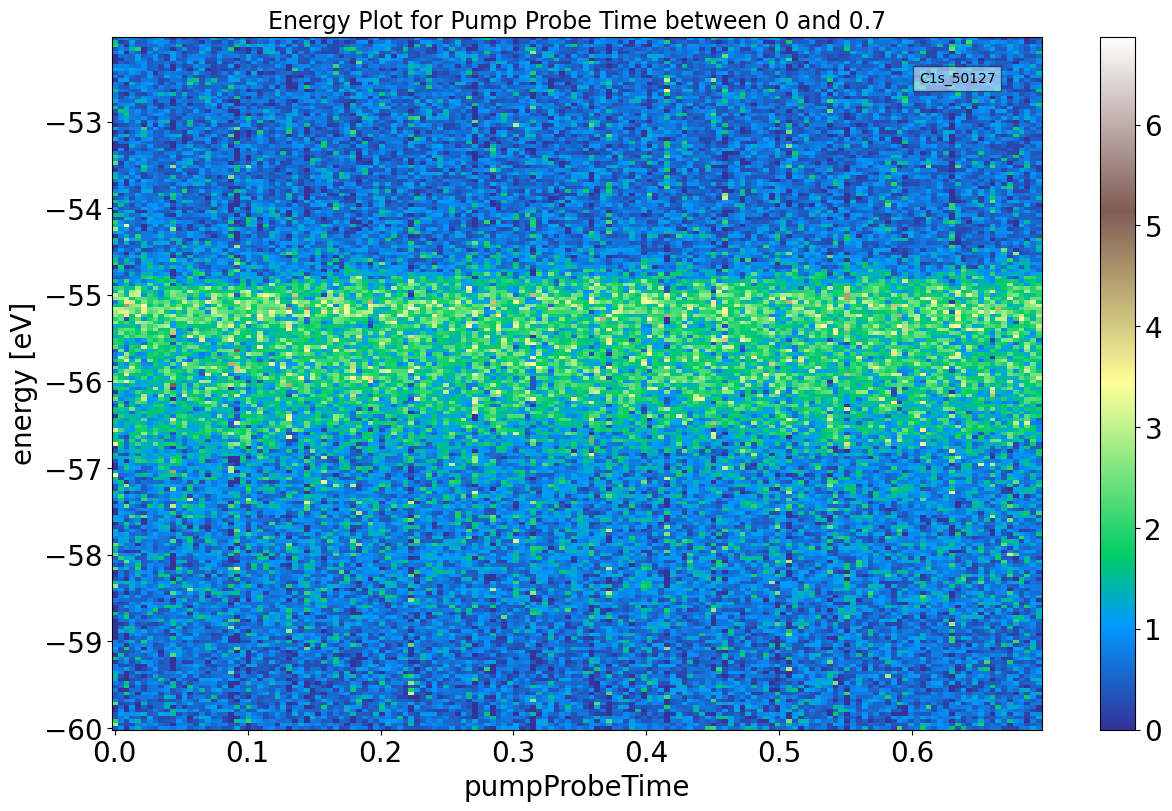

Processing C1s_50128
Configuration loaded from: [/home/noufalme/DataAnalysis/Scholz_Wind_update.yaml]
Default config loaded from: [/home/noufalme/DataAnalysis/sed/sed/.sed-venv/lib/python3.9/site-packages/sed/config/default.yaml]
Reading files: 33 new files of 33 total.


[Parallel(n_jobs=33)]: Using backend LokyBackend with 33 concurrent workers.
[Parallel(n_jobs=33)]: Done   4 out of  33 | elapsed:  1.9min remaining: 13.4min
[Parallel(n_jobs=33)]: Done   8 out of  33 | elapsed:  1.9min remaining:  5.9min
[Parallel(n_jobs=33)]: Done  12 out of  33 | elapsed:  1.9min remaining:  3.3min
[Parallel(n_jobs=33)]: Done  16 out of  33 | elapsed:  1.9min remaining:  2.0min
[Parallel(n_jobs=33)]: Done  20 out of  33 | elapsed:  1.9min remaining:  1.3min
[Parallel(n_jobs=33)]: Done  24 out of  33 | elapsed:  1.9min remaining:   43.7s
[Parallel(n_jobs=33)]: Done  28 out of  33 | elapsed:  1.9min remaining:   20.9s
[Parallel(n_jobs=33)]: Done  33 out of  33 | elapsed:  2.0min finished


All files converted successfully!
Filling nan values...
Combined parquet file saved.
loading complete in  188.15 s
Adding energy column to dataframe:


  0%|          | 0/1 [00:00<?, ?it/s]

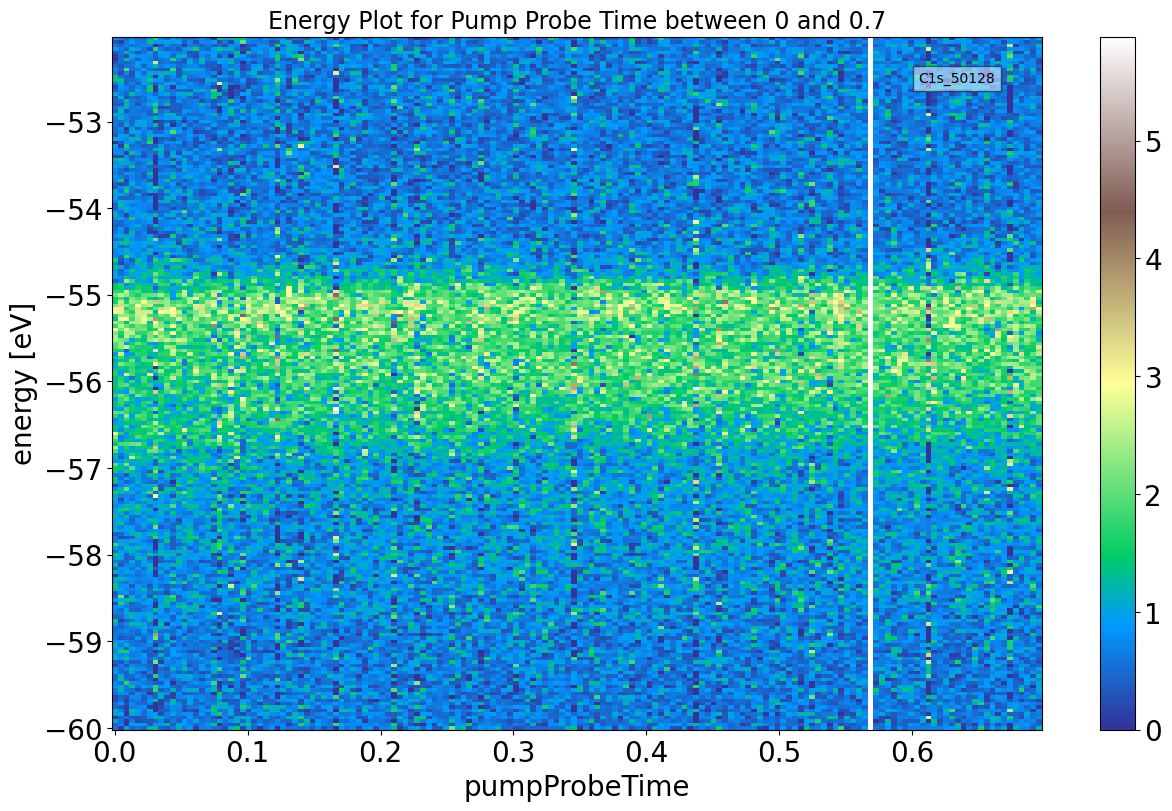

Processing C1s_50129
Configuration loaded from: [/home/noufalme/DataAnalysis/Scholz_Wind_update.yaml]
Default config loaded from: [/home/noufalme/DataAnalysis/sed/sed/.sed-venv/lib/python3.9/site-packages/sed/config/default.yaml]
Reading files: 19 new files of 19 total.


[Parallel(n_jobs=19)]: Using backend LokyBackend with 19 concurrent workers.
[Parallel(n_jobs=19)]: Done   2 out of  19 | elapsed:  1.6min remaining: 13.9min
[Parallel(n_jobs=19)]: Done   4 out of  19 | elapsed:  1.7min remaining:  6.5min
[Parallel(n_jobs=19)]: Done   6 out of  19 | elapsed:  1.7min remaining:  3.8min
[Parallel(n_jobs=19)]: Done   8 out of  19 | elapsed:  1.8min remaining:  2.4min
[Parallel(n_jobs=19)]: Done  10 out of  19 | elapsed:  1.8min remaining:  1.6min
[Parallel(n_jobs=19)]: Done  12 out of  19 | elapsed:  1.8min remaining:  1.1min
[Parallel(n_jobs=19)]: Done  14 out of  19 | elapsed:  1.8min remaining:   39.0s
[Parallel(n_jobs=19)]: Done  16 out of  19 | elapsed:  1.8min remaining:   20.6s
[Parallel(n_jobs=19)]: Done  19 out of  19 | elapsed:  1.9min finished


All files converted successfully!
Filling nan values...
Combined parquet file saved.
loading complete in  153.54 s
Adding energy column to dataframe:


  0%|          | 0/1 [00:00<?, ?it/s]

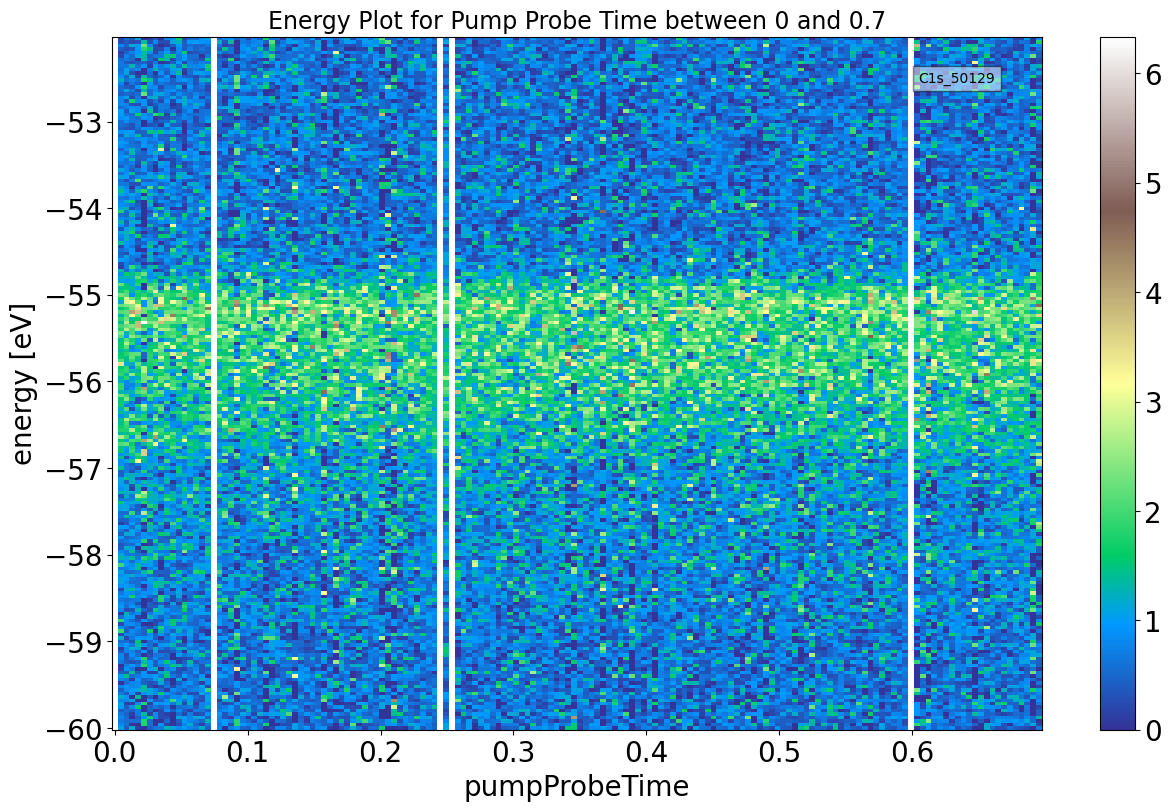

Processing C1s_50130
Configuration loaded from: [/home/noufalme/DataAnalysis/Scholz_Wind_update.yaml]
Default config loaded from: [/home/noufalme/DataAnalysis/sed/sed/.sed-venv/lib/python3.9/site-packages/sed/config/default.yaml]
Reading files: 18 new files of 18 total.


[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   3 out of  18 | elapsed:  1.1min remaining:  5.6min
[Parallel(n_jobs=18)]: Done   5 out of  18 | elapsed:  1.2min remaining:  3.2min
[Parallel(n_jobs=18)]: Done   7 out of  18 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=18)]: Done   9 out of  18 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=18)]: Done  11 out of  18 | elapsed:  1.5min remaining:   55.6s
[Parallel(n_jobs=18)]: Done  13 out of  18 | elapsed:  1.5min remaining:   33.9s
[Parallel(n_jobs=18)]: Done  15 out of  18 | elapsed:  1.5min remaining:   17.7s
[Parallel(n_jobs=18)]: Done  18 out of  18 | elapsed:  1.6min finished


All files converted successfully!
Filling nan values...
Combined parquet file saved.
loading complete in  128.16 s
Adding energy column to dataframe:


  0%|          | 0/1 [00:00<?, ?it/s]

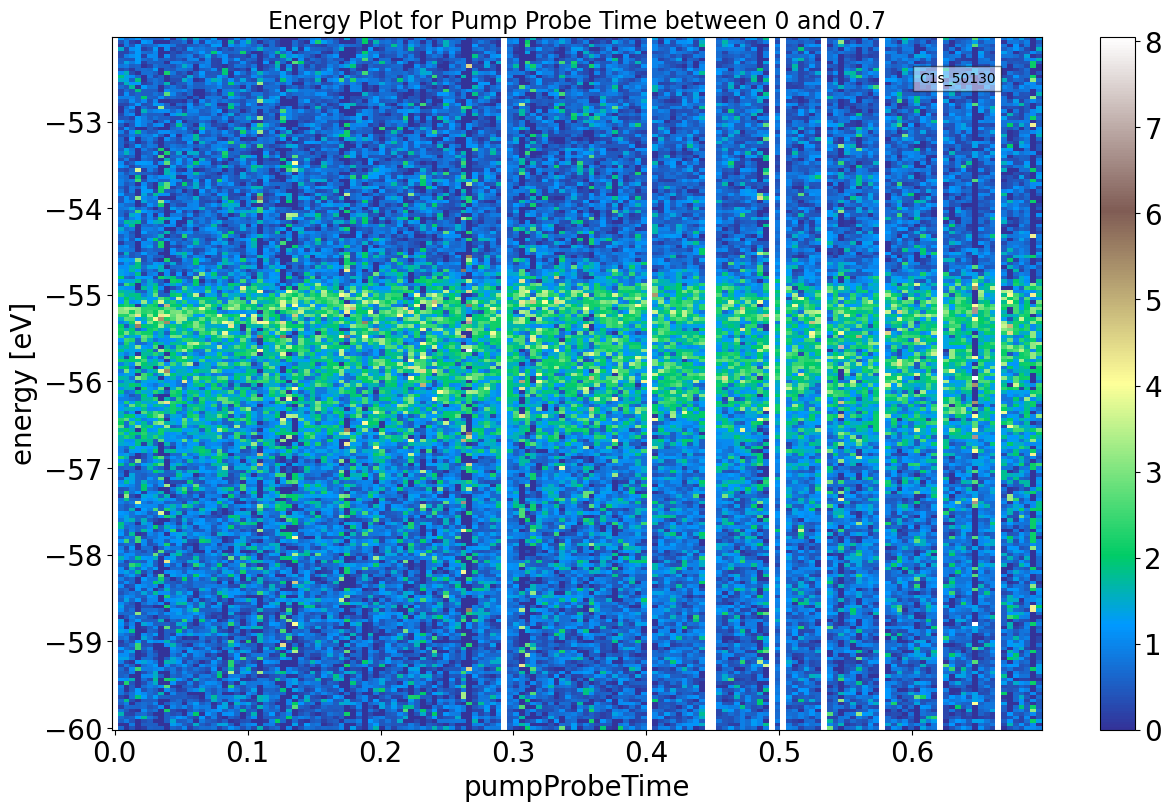

In [8]:
senorm_results = {}  # Dictionary to store senorm for each run
seb_results = {}  # Dictionary to store seb for each run


def process_and_plot_runs(run_numbers):
    """
    Iterates over the given run numbers, processes each run with the specified steps, and generates plots.

    Parameters:
    run_numbers (list): List of run numbers to process.
    """
    for run_number in run_numbers:
        # Define the name for the current run
        run_name = f"C1s_{run_number}"
        print(f"Processing {run_name}")

        # Initialize the SedProcessor with the current run number
        exec(
            f"{run_name} = SedProcessor("
            f"runs=[{run_number}], "
            "config=config, "
            "collect_metadata=True, "
            "save_parquet=True, "
            "force_recreate=True)"
        )

        # Access the dynamically created variable
        se = locals()[run_name]

        # Processing steps
        se.add_jitter()
        se.append_energy_axis()

        se._dataframe["energy"] += 229

        t0 = 3.53952100e03
        se._dataframe["pumpProbeTime"] = t0 - se._dataframe["delayStage"]

        # Filter the dataframe to use only data where 0 <= pumpProbeTime <= 0.7
        se._dataframe = se._dataframe[
            (se._dataframe["pumpProbeTime"] >= 0)
            & (se._dataframe["pumpProbeTime"] <= 0.7)
        ]

        # Adjust the ranges to accommodate the new filtered data
        ranges = [
            [-60, -52],
            [0, 0.7],
        ]  # Updated range for pumpProbeTime between 0 and 0.7
        bins = [200, 160]

        axes = ["energy", "pumpProbeTime"]
        seb = se.compute(axes=axes, ranges=ranges, bins=bins)  # Compute seb

        # Store seb in the dictionary with run_name as the key
        seb_results[run_name] = seb

        senorm = seb / seb.mean("energy")

        # Store senorm in the dictionary with run_name as the key
        senorm_results[run_name] = senorm

        # Plotting
        plt.figure(figsize=(15, 9))
        senorm.plot(cmap="terrain")

        # Add a box with the name in the top right corner
        plt.text(
            0.95,
            0.95,
            run_name,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.5),
            horizontalalignment="right",
            verticalalignment="top",
            transform=plt.gca().transAxes,
        )

        # Add a title to the plot
        plt.title("Energy Plot for Pump Probe Time between 0 and 0.7", fontsize=17)

        # Uncomment the following lines to save the plot in the folder
        # plot_path = os.path.join(folder_name, "{}_Eng_Delaystage.png".format(run_name))
        # plt.savefig(plot_path, dpi=200)

        plt.show()


# Example usage:
process_and_plot_runs(run_numbers)

# 3 peaks Doniach (99 seconds) 

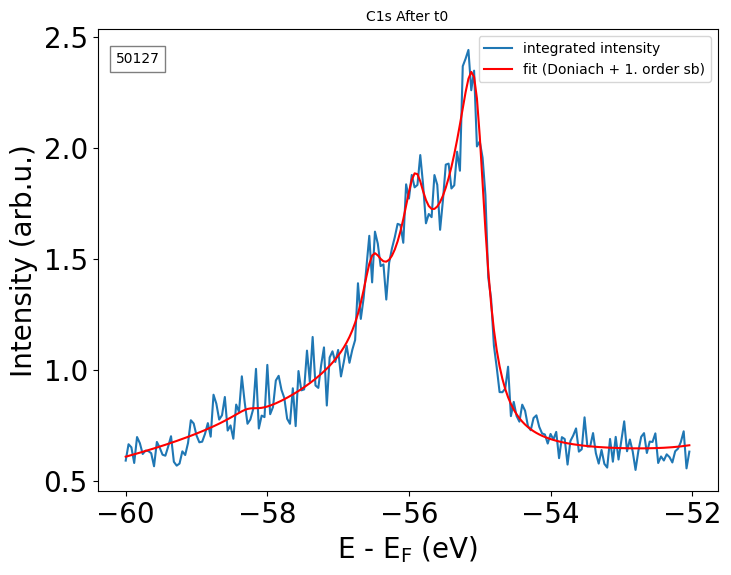

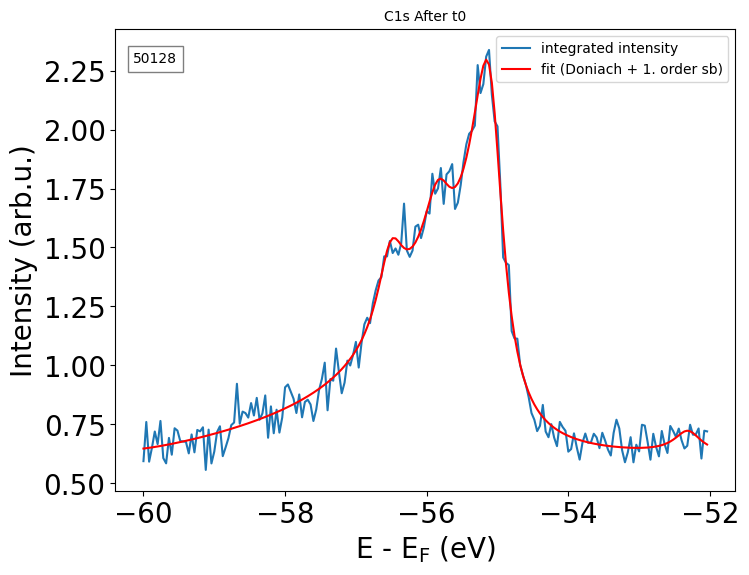

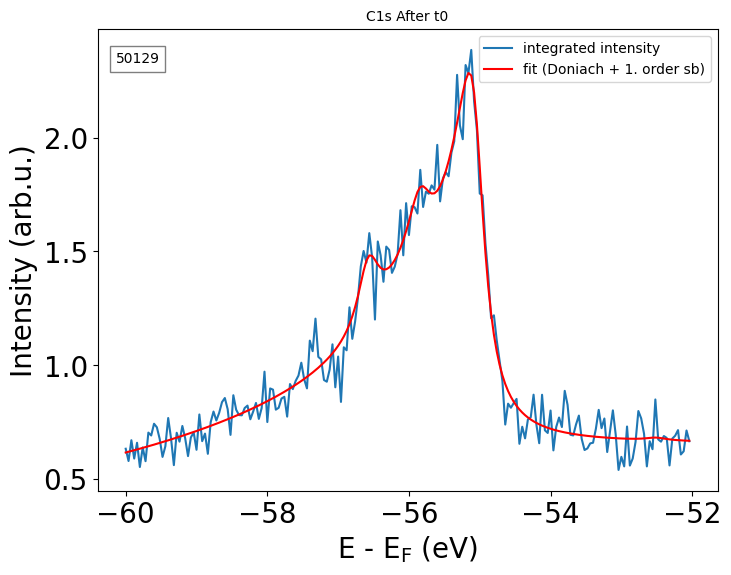

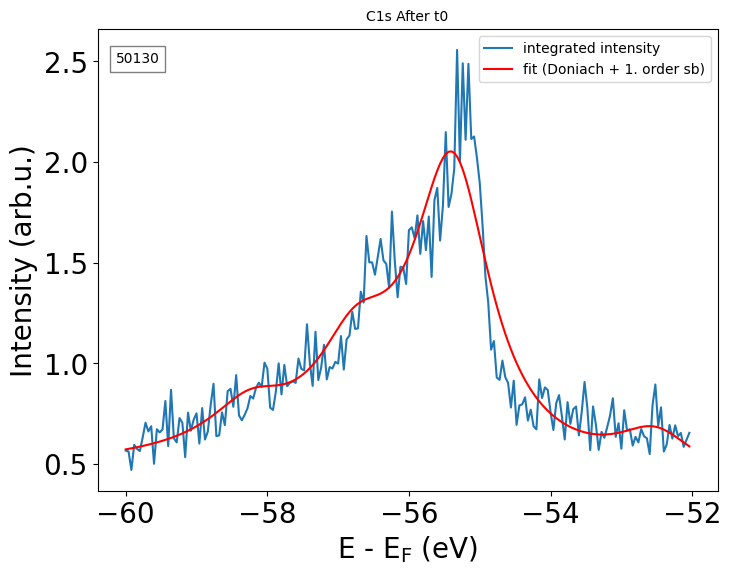

Parameters DataFrame:
              Run_50127     Run_50128     Run_50129     Run_50130
Parameter                                                        
A1         8.482648e-01  7.085425e-01  8.395380e-01  1.044159e+00
A2         5.206600e-02  8.688668e-02  5.214492e-02  5.080194e-06
A3         1.409099e-01  1.693729e-01  1.047503e-01  2.938345e-01
mu1       -5.502297e+01 -5.507478e+01 -5.505176e+01 -5.536555e+01
mu2       -5.651753e+01 -5.649895e+01 -5.657253e+01 -5.693709e+01
mu3       -5.589428e+01 -5.580886e+01 -5.582079e+01 -5.674784e+01
sigma1     1.775216e-01  2.257259e-01  1.820199e-01  6.630285e-01
sigma2     1.775216e-01  2.257259e-01  1.820199e-01  6.630285e-01
sigma3     1.775216e-01  2.257259e-01  1.820199e-01  6.630285e-01
gamma1     4.712650e-01  3.566588e-01  4.817582e-01  5.152857e-02
gamma2     4.934967e-10  4.058390e-02  4.855353e-10  2.199428e-01
gamma3     2.204494e-01  2.849520e-01  2.701238e-01  2.325234e-02
offset     5.994137e-01  6.044446e-01  6.490053e-01  3

In [9]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from lmfit import Model, Parameters
from scipy.ndimage import gaussian_filter

# Small value to avoid division by zero
epsilon = 1e-10

# DoniachModel definition
def DoniachModel(x, A, mu, sigma, gamma):
    # Ensure sigma and other parameters are valid to avoid NaN values
    sigma = max(sigma, epsilon)
    gamma = np.clip(gamma, epsilon, 1 - epsilon)  # Gamma should be between 0 and 1
    return (
        (A / (sigma ** (1 - gamma)))
        * np.cos(np.pi * gamma / 2 + (1 - gamma) * np.arctan((x - mu) / sigma))
        / (1 + ((x - mu) / sigma) ** 2) ** ((1 - gamma) / 2)
    )


# Background function
def background(signal, A, off, **kwargs):
    model = -np.cumsum(signal)
    model -= model.min()
    return model * A + off



# Modified Lines function compatible with DoniachModel with 3 peaks
def Lines(
    x,
    A1,
    A2,
    A3,
    mu1,
    mu2,
    mu3,
    sigma1,
    sigma2,
    sigma3,
    gamma1,
    gamma2,
    gamma3,
    bg_A,
    offset,
    A1p,
    A2p,
    A3p,
    A1m,
    A2m,
    A3m,
    delta_mu,
    **kwargs,
):
    # Main model with three Doniach peaks
    model = (
        DoniachModel(x, A1, mu1, sigma1, gamma1)
        + DoniachModel(x, A2, mu2, sigma2, gamma2)
        + DoniachModel(x, A3, mu3, sigma3, gamma3)
    )

    # Sidebands shifted by delta_mu
    sbp = (
        DoniachModel(x, A1 * A1p, mu1 + delta_mu, sigma1, gamma1)
        + DoniachModel(x, A2 * A2p, mu2 + delta_mu, sigma2, gamma2)
        + DoniachModel(x, A3 * A3p, mu3 + delta_mu, sigma3, gamma3)
    )
    sbm = (
        DoniachModel(x, A1 * A1m, mu1 - delta_mu, sigma1, gamma1)
        + DoniachModel(x, A2 * A2m, mu2 - delta_mu, sigma2, gamma2)
        + DoniachModel(x, A3 * A3m, mu3 - delta_mu, sigma3, gamma3)
    )

    # Combine the models
    model = model + sbp + sbm

    # Add background
    bg = background(model, bg_A, offset)

    return model + bg


# Initialize an empty DataFrame to store parameters
df_params = pd.DataFrame()

# Process each run number
for run_number in run_numbers:
    data = xr.apply_ufunc(gaussian_filter, senorm_results[f"C1s_{run_number}"], (0, 0))

    mod = Model(Lines)
    pfit = Parameters()
    pfit.add(name="A1", value=23.274, min=0)  # Initial guess for the 1 peak
    pfit.add(name="A2", value=12.899, min=0)  # Initial guess for the 2 peak
    pfit.add(name="A3", value=10.0, min=0)  # Initial guess for the 3 peak
    pfit.add(name="mu1", value=-55.64)  # Initial guess for the 1 peak position
    pfit.add(name="mu2", value=-56.5)  # Initial guess for the 2 peak position
    pfit.add(name="mu3", value=-57.0)  # Initial guess for the 3 peak position
    pfit.add(name="sigma1", value=0.205, min=epsilon)
    pfit.add(name="sigma2", expr="sigma1")
    pfit.add(name="sigma3", expr="sigma1")  # Assuming same width for simplicity
    pfit.add(name="gamma1", value=0.09, min=epsilon, max=1 - epsilon)
    pfit.add(name="gamma2", value=0.05, min=epsilon, max=1 - epsilon)
    pfit.add(name="gamma3", value=0.07, min=epsilon, max=1 - epsilon)
    pfit.add(name="offset", value=0.1)
    pfit.add(name="bg_A", value=0.00158053)
    pfit.add(name="A1p", value=0.004, min=0)
    pfit.add(name="A2p", value=0.023, min=0)
    pfit.add(name="A3p", value=0.01, min=0)
    pfit.add(name="A1m", expr="A1p")
    pfit.add(name="A2m", expr="A2p")
    pfit.add(name="A3m", expr="A3p")
    pfit.add(name="delta_mu", value=1.2)

    line = data.sel(energy=slice(-60, -52), pumpProbeTime=slice(-0.2, 0.2)).mean(
        "pumpProbeTime"
    )
    y = line
    x = y.energy.values
    result = mod.fit(line, params=pfit, x=x)

    # Append parameters to DataFrame
    df_run_params = pd.DataFrame(
        {
            "Parameter": result.params.keys(),
            f"Run_{run_number}": [
                result.params[param].value for param in result.params.keys()
            ],
        }
    )
    df_run_params.set_index("Parameter", inplace=True)
    df_params = pd.concat([df_params, df_run_params], axis=1)

    plt.figure(figsize=(8, 6))
    y.plot(label="integrated intensity")
    plt.plot(x, result.best_fit, "r-", label="fit (Doniach + 1. order sb)")
    plt.legend(loc=1, fontsize=10)
    plt.title(f"C1s After t0", fontsize=10)
    plt.xlabel("E - $ \mathrm{E}_\mathrm{F}$ (eV)")
    plt.ylabel("Intensity (arb.u.)")

    # Add a box with the name in the top right corner
    plt.text(
        0.1,
        0.95,
        run_number,
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.5),
        horizontalalignment="right",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plot_path = os.path.join(folder_name, f"{run_number}_C1s_Doniach_Aftert0.png")
    plt.savefig(plot_path, dpi=200)
    plt.show()

# Display the DataFrame with parameters
print("Parameters DataFrame:")
print(df_params)

# Plot parameters 

In [ ]:
# Small value to avoid division by zero
epsilon = 1e-10

# DoniachModel definition
def DoniachModel(x, A, mu, sigma, gamma):
    # Ensure sigma and other parameters are valid to avoid NaN values
    sigma = max(sigma, epsilon)
    gamma = np.clip(gamma, epsilon, 1 - epsilon)  # Gamma should be between 0 and 1
    return (
        (A / (sigma ** (1 - gamma)))
        * np.cos(np.pi * gamma / 2 + (1 - gamma) * np.arctan((x - mu) / sigma))
        / (1 + ((x - mu) / sigma) ** 2) ** ((1 - gamma) / 2)
    )

# Define the background function
def background(signal, A, off, **kwargs):
    model = -np.cumsum(signal)
    model -= model.min()
    return model * A + off

# Define the model function with Doniach profiles and background
def Lines(
    x,
    A1, A2, A3,
    mu1, mu2, mu3,
    sigma1, sigma2, sigma3,
    gamma1, gamma2, gamma3,
    bg_A, offset,
    A1p, A2p, A3p,
    A1m, A2m, A3m,
    delta_mu,
    **kwargs,
):
    # Main model with three Doniach peaks
    model = (
        DoniachModel(x, A1, mu1, sigma1, gamma1) +
        DoniachModel(x, A2, mu2, sigma2, gamma2) +
        DoniachModel(x, A3, mu3, sigma3, gamma3)
    )

    # Sidebands shifted by delta_mu for three peaks
    sbp = (
        DoniachModel(x, A1 * A1p, mu1 + delta_mu, sigma1, gamma1) +
        DoniachModel(x, A2 * A2p, mu2 + delta_mu, sigma2, gamma2) +
        DoniachModel(x, A3 * A3p, mu3 + delta_mu, sigma3, gamma3)
    )
    sbm = (
        DoniachModel(x, A1 * A1m, mu1 - delta_mu, sigma1, gamma1) +
        DoniachModel(x, A2 * A2m, mu2 - delta_mu, sigma2, gamma2) +
        DoniachModel(x, A3 * A3m, mu3 - delta_mu, sigma3, gamma3)
    )

    # Combine the models
    model = model + sbp + sbm

    # Add background
    bg = background(model, bg_A, offset)

    return model + bg

# Function to perform fitting and return results
def lineshape(run_number):
    # Ensure the correct dataset is selected
    data = xr.apply_ufunc(gaussian_filter, senorm_results[f"C1s_{run_number}"], (0, 0))

    # Adjusted parameters to match Doniach model
    mod = Model(Lines)
    pfit = Parameters()
    pfit.add(name="A1", value=1.0363, min=0)
    pfit.add(name="A2", value=1.4638, min=0)
    pfit.add(name="A3", value=1.2, min=0)  # Example initial value
    pfit.add(name="mu1", value=-55.2525)
    pfit.add(name="mu2", value=-56.2170)
    pfit.add(name="mu3", value=-57.0)  # Example initial value
    pfit.add(name="sigma1", value=0.2814, min=epsilon)
    pfit.add(name="sigma2", expr="sigma1")
    pfit.add(name="sigma3", expr="sigma1")  # Keeping same for simplicity, modify as needed
    pfit.add(name="gamma1", value=3.1997 * (10 ** (-9)), min=epsilon, max=1 - epsilon)
    pfit.add(name="gamma2", value=0.400, min=epsilon, max=0.4)
    pfit.add(name="gamma3", value=0.3, min=epsilon, max=0.4)  # Example initial value
    pfit.add(name="bg_A", value=0.0009)
    pfit.add(name="offset", value=0.6232)
    pfit.add(name="A1p", value=0.0517, min=0)
    pfit.add(name="A2p", value=0.0874, min=0)
    pfit.add(name="A3p", value=0.05, min=0)  # Example initial value
    pfit.add(name="A1m", expr="A1p")
    pfit.add(name="A2m", expr="A2p")
    pfit.add(name="A3m", expr="A3p")  # Example initial value
    pfit.add(name="delta_mu", value=1.2)

    line = data.sel(energy=slice(-60, -52), pumpProbeTime=slice(-0.2, 0.2)).mean(
        "pumpProbeTime"
    )
    y = line
    x = y.energy.values

    print("Fitting data for run number:", run_number)
    result = mod.fit(line, params=pfit, x=x)
    Params1 = result.params

    guess = Parameters()
    vary = [
        "A1", "A2", "A3",
        "mu1", "mu2", "mu3",
        "sigma1", "sigma2", "sigma3",
        "gamma1", "gamma2", "gamma3",
        "A1p", "A2p", "A3p"
    ]
    Expr = ["A1m", "A2m", "A3m"]

    for item in Params1:
        if item in Expr:
            guess.add(item, Params1[item].value, expr=Params1[item].expr)
        else:
            guess.add(
                item,
                Params1[item].value,
                min=Params1[item].min,
                max=Params1[item].max,
                vary=item in vary,
            )

    Fit1 = []
    for line in xr.apply_ufunc(
        gaussian_filter,
        senorm_results[f"C1s_{run_number}"].sel(energy=slice(-59, -52)),
        (0.0, 0.0),
    ).T:
        x = line.energy.values
        result = mod.fit(line, params=guess, x=x)
        Params = result.params
        Fit1.append(Params)

    return Fit1

# Perform fitting and collect results
all_results = {}
for run_number in run_numbers:
    fits = lineshape(run_number)
    all_results[run_number] = fits

# Create a DataFrame for parameters
param_dict = {
    param: []
    for param in [
        "run_number",
        "mu1", "mu2", "mu3",
        "sigma1", "sigma2", "sigma3",
        "gamma1", "gamma2", "gamma3",
        "bg_A", "offset",
        "A1p", "A2p", "A3p",
        "A1m", "A2m", "A3m",
        "delta_mu",
    ]
}
for run_number, fits in all_results.items():
    for i, fit in enumerate(fits):
        param_dict["run_number"].append(run_number)
        param_dict["mu1"].append(fit["mu1"].value)
        param_dict["mu2"].append(fit["mu2"].value)
        param_dict["mu3"].append(fit["mu3"].value)
        param_dict["sigma1"].append(fit["sigma1"].value)
        param_dict["sigma2"].append(fit["sigma2"].value)
        param_dict["sigma3"].append(fit["sigma3"].value)
        param_dict["gamma1"].append(fit["gamma1"].value)
        param_dict["gamma2"].append(fit["gamma2"].value)
        param_dict["gamma3"].append(fit["gamma3"].value)
        param_dict["bg_A"].append(fit["bg_A"].value)
        param_dict["offset"].append(fit["offset"].value)
        param_dict["A1p"].append(fit["A1p"].value)
        param_dict["A2p"].append(fit["A2p"].value)
        param_dict["A3p"].append(fit["A3p"].value)
        param_dict["A1m"].append(fit["A1m"].value)
        param_dict["A2m"].append(fit["A2m"].value)
        param_dict["A3m"].append(fit["A3m"].value)
        param_dict["delta_mu"].append(fit["delta_mu"].value)

params_df = pd.DataFrame(param_dict)

# Plotting parameters against pumpProbeTime for each run number
for param in [
    "mu1", "mu2", "mu3",
    "sigma1", "sigma2", "sigma3",
    "gamma1", "gamma2", "gamma3",
    "bg_A", "offset",
    "A1p", "A2p", "A3p",
    "A1m", "A2m", "A3m",
    "delta_mu",
]:
    plt.figure(figsize=(16, 6))

    # Loop over run_numbers to maintain order
    for run_number in run_numbers:
        group = params_df[params_df["run_number"] == run_number]
        plt.plot(data.pumpProbeTime, group[param], label=f"Run {run_number}")

    plt.title(param)
    plt.xlabel("Pump Probe Time")
    plt.ylabel("Parameter Value")
    plt.legend(loc="best", fontsize=10)
    plot_path = os.path.join(folder_name, f"{param}_C1s_Doniach_aftert0.png")
    plt.savefig(plot_path, dpi=200)
    plt.show()


Fitting data for run number: 50127
Fitting data for run number: 50128
